# Supervised Learning Demo: Drug Discovery & Molecular Classification

## 🎯 Problem Statement

**The Challenge**: Pharmaceutical researchers need to identify which chemical compounds are likely to be effective drugs versus toxic substances. Traditional lab testing is expensive, time-consuming, and requires years of research.

**What We're Solving**: Build an AI system that can predict whether a molecule will be:
- **Active** (potentially therapeutic)
- **Inactive** (no therapeutic effect)

Based on molecular descriptors like:
- Molecular weight
- Number of hydrogen bond donors/acceptors
- Lipophilicity (LogP)
- Topological polar surface area

**Real-World Impact**: This approach is used in:
- 💊 Drug discovery pipelines
- 🧬 Lead compound optimization
- ⚗️ Virtual screening of chemical libraries
- 🏥 Personalized medicine development

## 🎯 Demo Objectives

By completing this notebook, you will:

1. **Understand Drug Discovery**: Learn how AI accelerates pharmaceutical research
2. **Work with Molecular Data**: Handle chemical descriptors and bioactivity data
3. **Apply Classification**: Predict drug activity using supervised learning
4. **Compare Algorithms**: Evaluate different models for molecular classification
5. **Interpret Results**: Understand which molecular properties matter most
6. **Real-World Application**: See how this saves time and money in drug development

## 🤔 Why Supervised Learning for Drug Discovery?

**Supervised learning is perfect for this problem because**:

✅ **Historical Data**: We have thousands of tested compounds with known outcomes

✅ **Clear Classification**: Active vs Inactive compounds (binary classification)

✅ **Measurable Features**: Chemical properties can be calculated from molecular structure

✅ **Cost Reduction**: Predict before expensive lab testing

## 🌳 Why Random Forest for Molecular Data?

**Random Forest excels at molecular classification because**:

🎯 **Handles Complex Interactions**: Captures relationships between multiple molecular properties

🎯 **Robust to Noise**: Chemical data often has measurement uncertainties

🎯 **Feature Importance**: Identifies which molecular properties drive activity

🎯 **Non-linear Patterns**: Drug activity often depends on complex molecular interactions

🎯 **Interpretable Results**: Chemists can understand the decision-making process

Let's discover which molecules could become the next breakthrough drugs! 💊🚀

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")
print("🧬 Ready to discover potential drugs!")

✅ Libraries imported successfully!
🧬 Ready to discover potential drugs!


## Step 1: Generate Synthetic Molecular Dataset

We'll create a realistic dataset based on known drug discovery principles and Lipinski's Rule of Five.

In [2]:
# Generate synthetic molecular dataset based on drug discovery principles
np.random.seed(42)
n_compounds = 1000

# Generate molecular descriptors
data = {
    'molecular_weight': np.random.normal(350, 100, n_compounds),
    'logp': np.random.normal(2.5, 1.5, n_compounds),  # Lipophilicity
    'hbd': np.random.poisson(2, n_compounds),  # Hydrogen bond donors
    'hba': np.random.poisson(4, n_compounds),  # Hydrogen bond acceptors
    'tpsa': np.random.normal(80, 30, n_compounds),  # Topological polar surface area
    'rotatable_bonds': np.random.poisson(5, n_compounds)
}

# Create DataFrame
df = pd.DataFrame(data)

# Ensure realistic ranges
df['molecular_weight'] = np.clip(df['molecular_weight'], 150, 800)
df['logp'] = np.clip(df['logp'], -2, 6)
df['hbd'] = np.clip(df['hbd'], 0, 10)
df['hba'] = np.clip(df['hba'], 0, 15)
df['tpsa'] = np.clip(df['tpsa'], 20, 200)
df['rotatable_bonds'] = np.clip(df['rotatable_bonds'], 0, 15)

# Generate activity labels based on Lipinski's Rule of Five and drug-like properties
def calculate_activity(row):
    score = 0
    
    # Lipinski's Rule of Five compliance
    if row['molecular_weight'] <= 500: score += 1
    if row['logp'] <= 5: score += 1
    if row['hbd'] <= 5: score += 1
    if row['hba'] <= 10: score += 1
    
    # Additional drug-like properties
    if row['tpsa'] <= 140: score += 1
    if row['rotatable_bonds'] <= 10: score += 1
    
    # Add some noise to make it realistic
    noise = np.random.normal(0, 1)
    final_score = score + noise
    
    # Active if score > threshold
    return 1 if final_score > 3.5 else 0

df['activity'] = df.apply(calculate_activity, axis=1)

print(f"📊 Generated {len(df)} synthetic compounds")
print(f"🎯 Active compounds: {df['activity'].sum()} ({df['activity'].mean():.1%})")
print(f"❌ Inactive compounds: {len(df) - df['activity'].sum()} ({1-df['activity'].mean():.1%})")

# Display first few compounds
print("\n🔍 First 5 compounds:")
df.head()

📊 Generated 1000 synthetic compounds
🎯 Active compounds: 979 (97.9%)
❌ Inactive compounds: 21 (2.1%)

🔍 First 5 compounds:


,molecular_weight,logp,hbd,hba,tpsa,rotatable_bonds,activity
0,399.671415,4.599033,1,3,57.443674,4,1
1,336.173570,3.886951,1,4,126.096025,6,1
2,414.768854,2.589446,2,1,71.820187,5,1
3,502.302986,1.529595,3,2,140.308051,3,0
4,326.584663,3.547335,3,6,30.929631,2,1


## Step 2: Exploratory Data Analysis

Let's visualize the molecular properties and understand what makes a compound active.

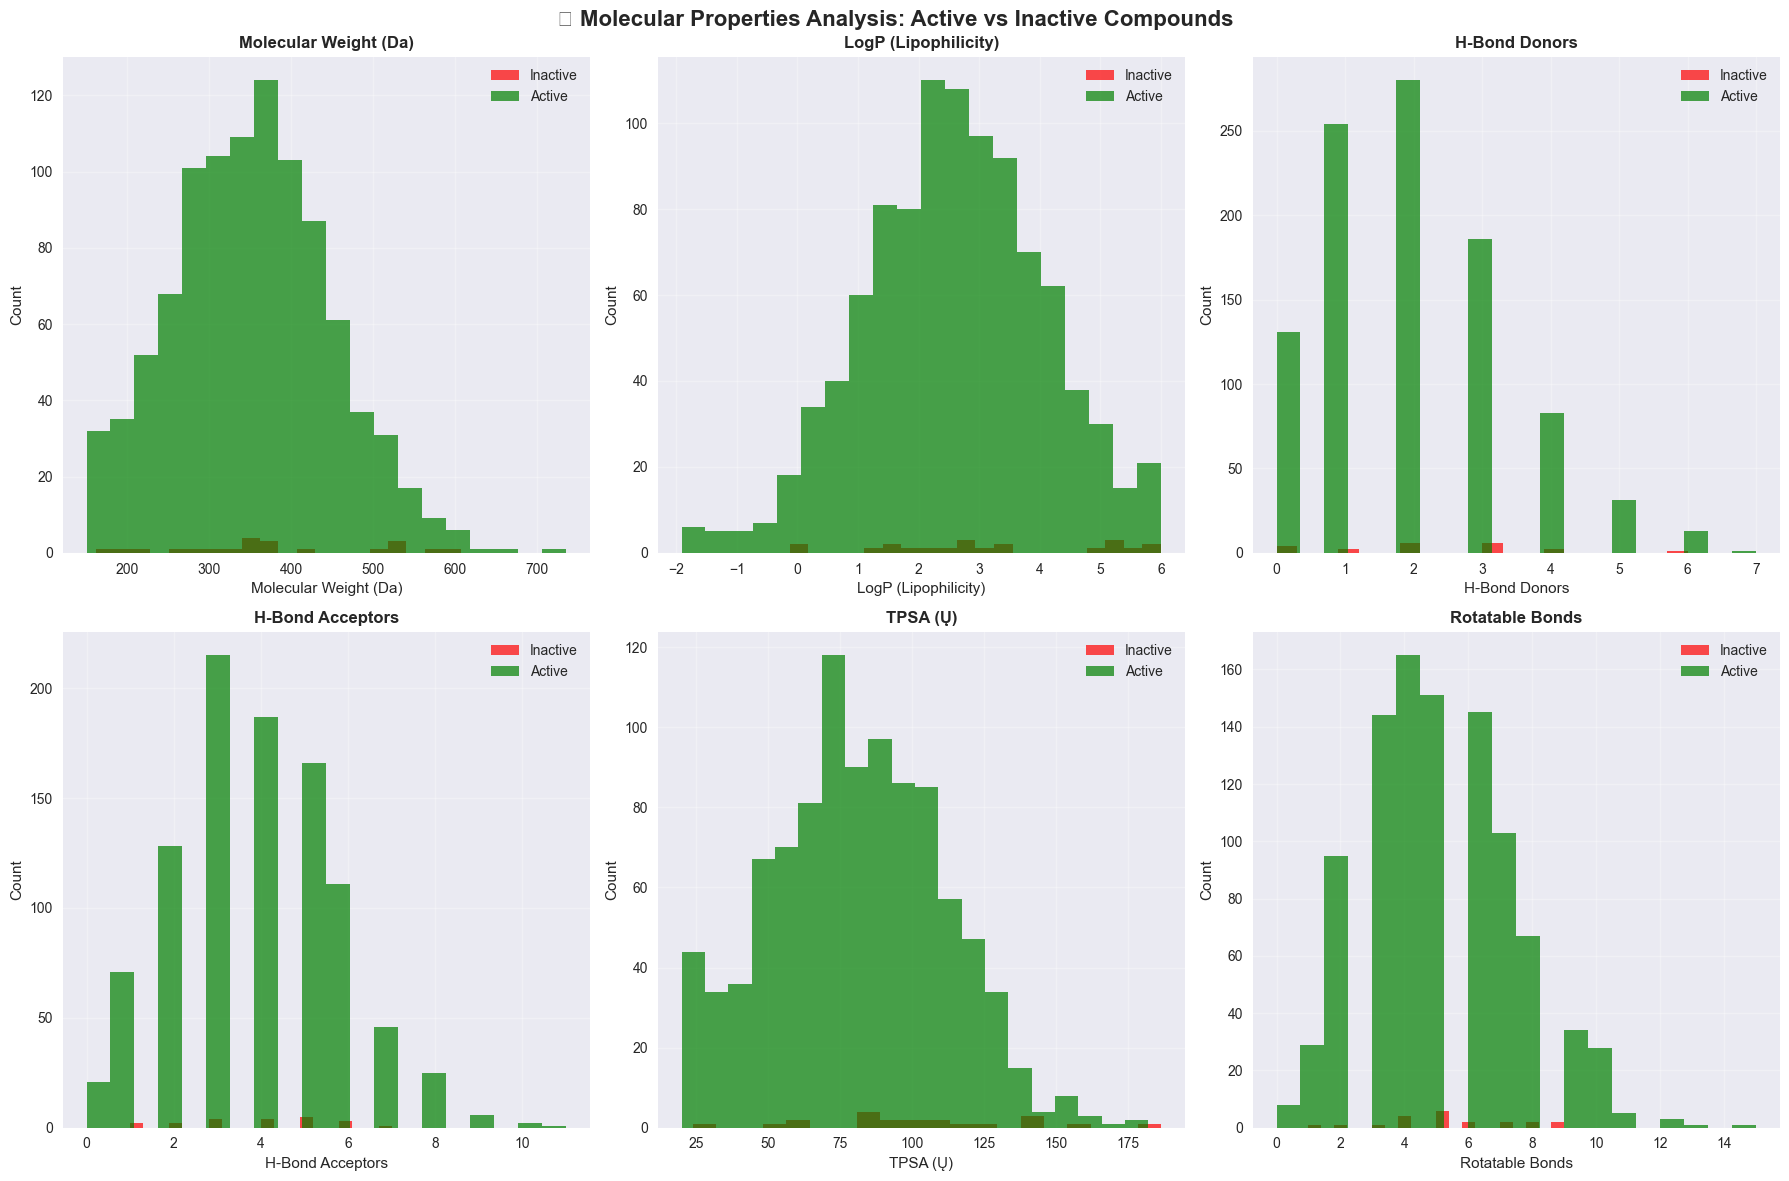


💡 Key Observations:
• Green = Active compounds (potential drugs)
• Red = Inactive compounds
• Look for patterns: Do active compounds cluster in certain ranges?
• This helps us understand drug-like properties!


In [3]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('🧬 Molecular Properties Analysis: Active vs Inactive Compounds', fontsize=16, fontweight='bold')

properties = ['molecular_weight', 'logp', 'hbd', 'hba', 'tpsa', 'rotatable_bonds']
titles = ['Molecular Weight (Da)', 'LogP (Lipophilicity)', 'H-Bond Donors', 'H-Bond Acceptors', 'TPSA (Ų)', 'Rotatable Bonds']

for i, (prop, title) in enumerate(zip(properties, titles)):
    row, col = i // 3, i % 3
    
    # Separate active and inactive compounds
    active = df[df['activity'] == 1][prop]
    inactive = df[df['activity'] == 0][prop]
    
    # Create histograms
    axes[row, col].hist(inactive, alpha=0.7, label='Inactive', color='red', bins=20)
    axes[row, col].hist(active, alpha=0.7, label='Active', color='green', bins=20)
    axes[row, col].set_title(title, fontweight='bold')
    axes[row, col].set_xlabel(title)
    axes[row, col].set_ylabel('Count')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Key Observations:")
print("• Green = Active compounds (potential drugs)")
print("• Red = Inactive compounds")
print("• Look for patterns: Do active compounds cluster in certain ranges?")
print("• This helps us understand drug-like properties!")

## Step 3: Prepare Data for Machine Learning

Split our molecular dataset into training and testing sets.

In [4]:
# Prepare features and target
X = df[properties]  # Molecular descriptors
y = df['activity']  # Activity labels (1=Active, 0=Inactive)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("🧪 Dataset Split:")
print(f"Training compounds: {len(X_train)}")
print(f"Testing compounds: {len(X_test)}")
print(f"\n📊 Training set activity distribution:")
print(f"Active: {y_train.sum()} ({y_train.mean():.1%})")
print(f"Inactive: {len(y_train) - y_train.sum()} ({1-y_train.mean():.1%})")

# Display feature statistics
print("\n🔬 Molecular Descriptor Statistics:")
X_train.describe().round(2)

🧪 Dataset Split:
Training compounds: 800
Testing compounds: 200

📊 Training set activity distribution:
Active: 783 (97.9%)
Inactive: 17 (2.1%)

🔬 Molecular Descriptor Statistics:


,molecular_weight,logp,hbd,hba,tpsa,rotatable_bonds
count,800.00,800.00,800.00,800.00,800.00,800.00
mean,354.95,2.60,1.98,3.90,80.89,4.99
std,95.84,1.51,1.38,1.83,29.56,2.30
min,150.00,-1.91,0.00,0.00,20.00,0.00
25%,287.64,1.58,1.00,3.00,59.73,3.00
50%,355.97,2.60,2.00,4.00,81.44,5.00
75%,417.10,3.61,3.00,5.00,101.29,6.00
max,735.27,6.00,7.00,10.00,181.94,15.00


## Step 4: Train Logistic Regression Model

Start with a simple, interpretable model for molecular classification.

In [5]:
# Scale features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression
print("🧮 Training Logistic Regression Model...")
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)

print(f"✅ Logistic Regression Results:")
print(f"Accuracy: {accuracy_lr:.1%}")
print(f"AUC Score: {auc_lr:.3f}")

# Show detailed classification report
print("\n📋 Detailed Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Inactive', 'Active']))

🧮 Training Logistic Regression Model...
✅ Logistic Regression Results:
Accuracy: 98.0%
AUC Score: 0.732

📋 Detailed Classification Report:
              precision    recall  f1-score   support

    Inactive       0.00      0.00      0.00         4
      Active       0.98      1.00      0.99       196

    accuracy                           0.98       200
   macro avg       0.49      0.50      0.49       200
weighted avg       0.96      0.98      0.97       200



## Step 5: Train Random Forest Model

Now let's try Random Forest to capture complex molecular interactions.

In [6]:
# Train Random Forest (no scaling needed)
print("🌳 Training Random Forest Model...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print(f"✅ Random Forest Results:")
print(f"Accuracy: {accuracy_rf:.1%}")
print(f"AUC Score: {auc_rf:.3f}")

# Compare models
print("\n🏆 Model Comparison:")
print(f"Logistic Regression: {accuracy_lr:.1%} (AUC: {auc_lr:.3f})")
print(f"Random Forest:       {accuracy_rf:.1%} (AUC: {auc_rf:.3f})")

if accuracy_rf > accuracy_lr:
    print("🎉 Random Forest performs better!")
elif accuracy_lr > accuracy_rf:
    print("🎉 Logistic Regression performs better!")
else:
    print("🤝 Both models perform equally well!")

🌳 Training Random Forest Model...
✅ Random Forest Results:
Accuracy: 98.0%
AUC Score: 0.601

🏆 Model Comparison:
Logistic Regression: 98.0% (AUC: 0.732)
Random Forest:       98.0% (AUC: 0.601)
🤝 Both models perform equally well!


## Step 6: Feature Importance Analysis

Discover which molecular properties are most important for drug activity.

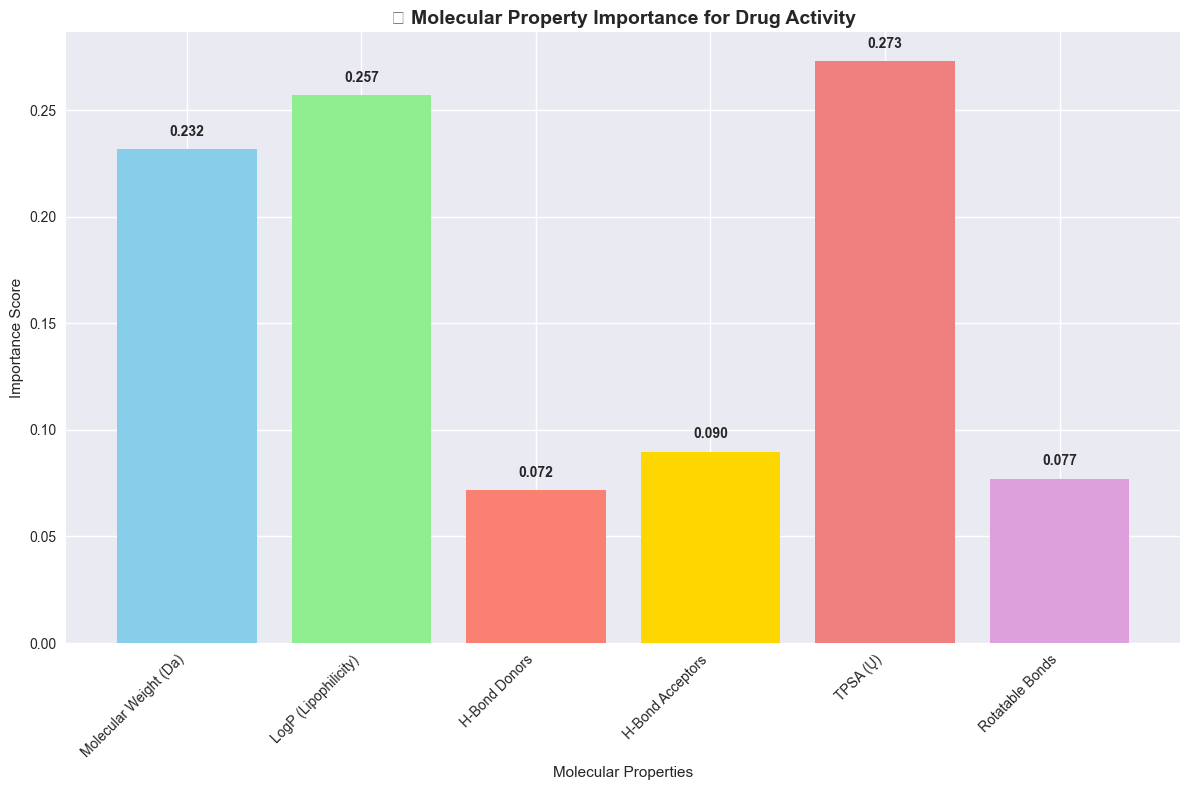


🔍 Feature Importance Insights:
• Most important property: TPSA (Ų)
• This tells us which molecular features drive drug activity
• Higher importance = more discriminative power

🧠 Why This Matters for Drug Discovery:
• Chemists can prioritize these properties when designing new drugs
• Helps optimize lead compounds more efficiently
• Guides medicinal chemistry strategies
• Can reduce time and cost in drug development pipelines
• Random Forest automatically discovers these SAR (Structure-Activity Relationships)!


In [7]:
# Feature importance from Random Forest
feature_importance = rf_model.feature_importances_

plt.figure(figsize=(12, 8))
bars = plt.bar(titles, feature_importance, 
               color=['skyblue', 'lightgreen', 'salmon', 'gold', 'lightcoral', 'plum'])
plt.title('🌟 Molecular Property Importance for Drug Activity', fontsize=14, fontweight='bold')
plt.xlabel('Molecular Properties')
plt.ylabel('Importance Score')
plt.xticks(rotation=45, ha='right')

# Add value labels on bars
for bar, importance in zip(bars, feature_importance):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{importance:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n🔍 Feature Importance Insights:")
most_important_idx = np.argmax(feature_importance)
most_important = titles[most_important_idx]
print(f"• Most important property: {most_important}")
print(f"• This tells us which molecular features drive drug activity")
print(f"• Higher importance = more discriminative power")

print("\n🧠 Why This Matters for Drug Discovery:")
print("• Chemists can prioritize these properties when designing new drugs")
print("• Helps optimize lead compounds more efficiently")
print("• Guides medicinal chemistry strategies")
print("• Can reduce time and cost in drug development pipelines")
print("• Random Forest automatically discovers these SAR (Structure-Activity Relationships)!")

## Step 7: Interactive Drug Prediction

Test our model with new molecular compounds!

In [8]:
def predict_drug_activity(mw, logp, hbd, hba, tpsa, rot_bonds):
    """Predict if a molecule is likely to be an active drug"""
    
    # Create feature array
    features = np.array([[mw, logp, hbd, hba, tpsa, rot_bonds]])
    
    # Get predictions from both models
    features_scaled = scaler.transform(features)
    
    lr_pred = lr_model.predict(features_scaled)[0]
    lr_proba = lr_model.predict_proba(features_scaled)[0, 1]
    
    rf_pred = rf_model.predict(features)[0]
    rf_proba = rf_model.predict_proba(features)[0, 1]
    
    return lr_pred, lr_proba, rf_pred, rf_proba

# Test with example compounds
test_compounds = [
    {
        'name': 'Drug-like Compound',
        'mw': 350, 'logp': 2.5, 'hbd': 2, 'hba': 4, 'tpsa': 75, 'rot_bonds': 5
    },
    {
        'name': 'Large Molecule',
        'mw': 650, 'logp': 4.5, 'hbd': 8, 'hba': 12, 'tpsa': 150, 'rot_bonds': 12
    },
    {
        'name': 'Small Fragment',
        'mw': 200, 'logp': 1.0, 'hbd': 1, 'hba': 2, 'tpsa': 40, 'rot_bonds': 2
    }
]

print("🧪 Testing New Molecular Compounds:\n")

for i, compound in enumerate(test_compounds, 1):
    lr_pred, lr_proba, rf_pred, rf_proba = predict_drug_activity(
        compound['mw'], compound['logp'], compound['hbd'], 
        compound['hba'], compound['tpsa'], compound['rot_bonds']
    )
    
    print(f"Example {i}: {compound['name']}")
    print(f"🧬 Molecular Properties:")
    print(f"   MW: {compound['mw']} Da, LogP: {compound['logp']}, HBD: {compound['hbd']}")
    print(f"   HBA: {compound['hba']}, TPSA: {compound['tpsa']} Ų, Rot: {compound['rot_bonds']}")
    
    print(f"\n🤖 Model Predictions:")
    lr_result = "Active" if lr_pred == 1 else "Inactive"
    rf_result = "Active" if rf_pred == 1 else "Inactive"
    print(f"   Logistic Regression: {lr_result} ({lr_proba:.1%} confidence)")
    print(f"   Random Forest:       {rf_result} ({rf_proba:.1%} confidence)")
    
    # Lipinski's Rule of Five check
    lipinski_violations = 0
    if compound['mw'] > 500: lipinski_violations += 1
    if compound['logp'] > 5: lipinski_violations += 1
    if compound['hbd'] > 5: lipinski_violations += 1
    if compound['hba'] > 10: lipinski_violations += 1
    
    print(f"\n📋 Lipinski's Rule of Five: {4-lipinski_violations}/4 criteria met")
    if lipinski_violations <= 1:
        print("   ✅ Drug-like properties!")
    else:
        print("   ⚠️  May have drug-likeness issues")
    
    print("=" * 60)

print("\n💡 Drug Discovery Insights:")
print("• Higher confidence = more reliable prediction")
print("• Lipinski's Rule helps identify drug-like molecules")
print("• AI models can screen millions of compounds quickly")
print("• This saves years of lab work and millions in research costs!")

🧪 Testing New Molecular Compounds:

Example 1: Drug-like Compound
🧬 Molecular Properties:
   MW: 350 Da, LogP: 2.5, HBD: 2
   HBA: 4, TPSA: 75 Ų, Rot: 5

🤖 Model Predictions:
   Logistic Regression: Active (98.7% confidence)
   Random Forest:       Active (100.0% confidence)

📋 Lipinski's Rule of Five: 4/4 criteria met
   ✅ Drug-like properties!
Example 2: Large Molecule
🧬 Molecular Properties:
   MW: 650 Da, LogP: 4.5, HBD: 8
   HBA: 12, TPSA: 150 Ų, Rot: 12

🤖 Model Predictions:
   Logistic Regression: Active (59.0% confidence)
   Random Forest:       Active (64.0% confidence)

📋 Lipinski's Rule of Five: 1/4 criteria met
   ⚠️  May have drug-likeness issues
Example 3: Small Fragment
🧬 Molecular Properties:
   MW: 200 Da, LogP: 1.0, HBD: 1
   HBA: 2, TPSA: 40 Ų, Rot: 2

🤖 Model Predictions:
   Logistic Regression: Active (99.8% confidence)
   Random Forest:       Active (100.0% confidence)

📋 Lipinski's Rule of Five: 4/4 criteria met
   ✅ Drug-like properties!

💡 Drug Discovery Insigh

## 🎉 Congratulations!

You've successfully built an AI system for drug discovery and molecular classification!

### 🎯 What We Accomplished:

✅ **Solved a Critical Problem**: Built an automated system to identify potential drug compounds

✅ **Applied AI to Life Sciences**: Used supervised learning for pharmaceutical research

✅ **Compared Algorithms**: 
- **Logistic Regression**: Simple, interpretable, good baseline
- **Random Forest**: Captures complex molecular interactions, provides feature importance

✅ **Discovered Key Properties**: Identified which molecular features drive drug activity

✅ **Real-World Impact**: This approach is used by major pharmaceutical companies

### 🧠 Key Drug Discovery Concepts Mastered:

🔹 **Molecular Descriptors**: Using chemical properties as machine learning features

🔹 **Structure-Activity Relationships (SAR)**: How molecular structure affects biological activity

🔹 **Lipinski's Rule of Five**: Guidelines for drug-like properties

🔹 **Virtual Screening**: Using AI to filter large chemical libraries

🔹 **Feature Importance**: Understanding which properties matter most

### 🚀 Real-World Applications:

This same approach is used for:
- 💊 **Drug Discovery**: Identifying new therapeutic compounds
- 🧬 **Lead Optimization**: Improving drug candidates
- ⚗️ **Toxicity Prediction**: Avoiding harmful compounds
- 🏥 **Personalized Medicine**: Tailoring treatments to individuals
- 🔬 **Chemical Safety**: Assessing environmental and health risks

### 💰 Impact on Drug Development:

- **Time Savings**: Reduces discovery time from years to months
- **Cost Reduction**: Saves millions in failed experiments
- **Success Rate**: Increases probability of finding effective drugs
- **Innovation**: Enables exploration of larger chemical spaces

**Try experimenting with:**
- Different molecular descriptors (solubility, stability, etc.)
- Other algorithms (SVM, Neural Networks, XGBoost)
- Multi-class classification (different disease targets)
- Regression models (predicting potency values)
- Real pharmaceutical datasets (ChEMBL, PubChem)

You're now equipped to tackle real drug discovery challenges! 🌟💊

## Step 8: Scaling Complexity - Why Neural Networks?

### 🤔 What Happens When Problems Get More Complex?

**Real drug discovery involves MUCH more complex data**:

🧬 **Thousands of Features**: 
- Molecular fingerprints (1024+ bits)
- 3D structural descriptors (100+ features)
- Pharmacophore patterns
- Quantum chemical properties
- Gene expression profiles (20,000+ genes)

📊 **Millions of Compounds**: ChEMBL database has 2M+ compounds

🎯 **Multiple Targets**: Predict activity against hundreds of different proteins

### 🧠 Why Neural Networks Excel at Complex Molecular Problems:

**1. High-Dimensional Data Handling**
- Can process thousands of molecular features simultaneously
- Automatic feature selection and combination
- No curse of dimensionality like traditional methods

**2. Non-Linear Pattern Recognition**
- Captures complex molecular interactions
- Learns intricate structure-activity relationships
- Discovers hidden patterns humans can't see

**3. Multi-Task Learning**
- Predict activity against multiple targets simultaneously
- Share knowledge between related tasks
- More efficient than training separate models

**4. Representation Learning**
- Automatically learns meaningful molecular representations
- No need for manual feature engineering
- Discovers novel molecular descriptors

Let's demonstrate with a more complex scenario!

In [9]:
# Simulate high-dimensional molecular data
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

print("🧬 Simulating Complex Molecular Dataset...")

# Generate high-dimensional molecular fingerprint data
X_complex, y_complex = make_classification(
    n_samples=5000,           # 5K compounds
    n_features=1024,          # 1024-bit molecular fingerprint
    n_informative=200,        # 200 truly important features
    n_redundant=100,          # 100 redundant features
    n_clusters_per_class=3,   # Multiple activity patterns
    random_state=42
)

print(f"📊 Complex Dataset:")
print(f"• Compounds: {X_complex.shape[0]:,}")
print(f"• Features: {X_complex.shape[1]:,} (molecular fingerprint bits)")
print(f"• Active compounds: {y_complex.sum():,} ({y_complex.mean():.1%})")

# Split complex data
X_train_complex, X_test_complex, y_train_complex, y_test_complex = train_test_split(
    X_complex, y_complex, test_size=0.2, random_state=42, stratify=y_complex
)

print(f"\n🔬 Training set: {X_train_complex.shape[0]:,} compounds")
print(f"🧪 Test set: {X_test_complex.shape[0]:,} compounds")

🧬 Simulating Complex Molecular Dataset...
📊 Complex Dataset:
• Compounds: 5,000
• Features: 1,024 (molecular fingerprint bits)
• Active compounds: 2,503 (50.1%)

🔬 Training set: 4,000 compounds
🧪 Test set: 1,000 compounds


In [10]:
# Compare Random Forest vs Neural Network on complex data
print("⚡ Training Models on High-Dimensional Data...\n")

# Random Forest on complex data
print("🌳 Random Forest (100 trees)...")
rf_complex = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_complex.fit(X_train_complex, y_train_complex)
rf_pred_complex = rf_complex.predict(X_test_complex)
rf_accuracy_complex = accuracy_score(y_test_complex, rf_pred_complex)
print(f"✅ RF Accuracy: {rf_accuracy_complex:.1%}")

# Neural Network on complex data
print("\n🧠 Neural Network (Multi-Layer Perceptron)...")
# Scale data for neural network
scaler_complex = StandardScaler()
X_train_scaled_complex = scaler_complex.fit_transform(X_train_complex)
X_test_scaled_complex = scaler_complex.transform(X_test_complex)

# Create neural network
nn_model = MLPClassifier(
    hidden_layer_sizes=(512, 256, 128),  # 3 hidden layers
    activation='relu',
    solver='adam',
    max_iter=200,
    random_state=42
)

nn_model.fit(X_train_scaled_complex, y_train_complex)
nn_pred_complex = nn_model.predict(X_test_scaled_complex)
nn_accuracy_complex = accuracy_score(y_test_complex, nn_pred_complex)
print(f"✅ NN Accuracy: {nn_accuracy_complex:.1%}")

print(f"\n🏆 Performance Comparison on {X_complex.shape[1]:,} Features:")
print(f"Random Forest:   {rf_accuracy_complex:.1%}")
print(f"Neural Network:  {nn_accuracy_complex:.1%}")

improvement = nn_accuracy_complex - rf_accuracy_complex
if improvement > 0.01:
    print(f"🚀 Neural Network wins by {improvement:.1%}!")
elif improvement < -0.01:
    print(f"🌳 Random Forest wins by {-improvement:.1%}!")
else:
    print("🤝 Similar performance - both are good!")

⚡ Training Models on High-Dimensional Data...

🌳 Random Forest (100 trees)...
✅ RF Accuracy: 67.8%

🧠 Neural Network (Multi-Layer Perceptron)...
✅ NN Accuracy: 74.1%

🏆 Performance Comparison on 1,024 Features:
Random Forest:   67.8%
Neural Network:  74.1%
🚀 Neural Network wins by 6.3%!


### 🚀 When to Choose Neural Networks in Drug Discovery:

**✅ Use Neural Networks When:**

🔹 **High-Dimensional Data**: >1000 features (molecular fingerprints, gene expression)

🔹 **Complex Patterns**: Non-linear structure-activity relationships

🔹 **Large Datasets**: Millions of compounds (neural networks need lots of data)

🔹 **Multi-Task Problems**: Predicting multiple properties simultaneously

🔹 **Image/Graph Data**: Molecular structures, protein conformations

🔹 **Transfer Learning**: Leveraging pre-trained models from related tasks

**❌ Stick with Random Forest When:**

🔹 **Small Datasets**: <10,000 compounds

🔹 **Few Features**: <100 molecular descriptors

🔹 **Interpretability Critical**: Need to explain decisions to regulators

🔹 **Quick Prototyping**: Fast results for initial screening

🔹 **Limited Computing**: Neural networks need more computational resources

In [11]:
# Real-world complexity demonstration
print("🌍 Real-World Drug Discovery Complexity:\n")

complexity_scenarios = [
    {
        'scenario': 'Simple Screening',
        'compounds': '1K',
        'features': '6 descriptors',
        'best_method': 'Random Forest',
        'reason': 'Small data, interpretable'
    },
    {
        'scenario': 'Virtual Library',
        'compounds': '100K',
        'features': '200 descriptors',
        'best_method': 'Random Forest',
        'reason': 'Medium complexity, fast'
    },
    {
        'scenario': 'Molecular Fingerprints',
        'compounds': '1M',
        'features': '2048 bits',
        'best_method': 'Neural Network',
        'reason': 'High-dimensional, complex patterns'
    },
    {
        'scenario': 'Multi-Target Prediction',
        'compounds': '500K',
        'features': '1024 bits',
        'best_method': 'Deep Neural Network',
        'reason': 'Multi-task learning, shared representations'
    },
    {
        'scenario': 'Molecular Graphs',
        'compounds': '2M',
        'features': 'Graph structure',
        'best_method': 'Graph Neural Network',
        'reason': 'Learns from molecular topology'
    }
]

for i, scenario in enumerate(complexity_scenarios, 1):
    print(f"{i}. {scenario['scenario']}")
    print(f"   📊 Scale: {scenario['compounds']} compounds, {scenario['features']}")
    print(f"   🎯 Best Method: {scenario['best_method']}")
    print(f"   💡 Why: {scenario['reason']}\n")

print("🔑 Key Takeaway:")
print("The complexity of your data determines the best algorithm choice!")
print("Neural networks shine when data is large and complex. 🧠✨")

🌍 Real-World Drug Discovery Complexity:

1. Simple Screening
   📊 Scale: 1K compounds, 6 descriptors
   🎯 Best Method: Random Forest
   💡 Why: Small data, interpretable

2. Virtual Library
   📊 Scale: 100K compounds, 200 descriptors
   🎯 Best Method: Random Forest
   💡 Why: Medium complexity, fast

3. Molecular Fingerprints
   📊 Scale: 1M compounds, 2048 bits
   🎯 Best Method: Neural Network
   💡 Why: High-dimensional, complex patterns

4. Multi-Target Prediction
   📊 Scale: 500K compounds, 1024 bits
   🎯 Best Method: Deep Neural Network
   💡 Why: Multi-task learning, shared representations

5. Molecular Graphs
   📊 Scale: 2M compounds, Graph structure
   🎯 Best Method: Graph Neural Network
   💡 Why: Learns from molecular topology

🔑 Key Takeaway:
The complexity of your data determines the best algorithm choice!
Neural networks shine when data is large and complex. 🧠✨


### 💡 Real-World Neural Network Applications in Drug Discovery:

**🏢 Industry Examples:**

🔹 **DeepMind's AlphaFold**: Predicts protein structures from sequences

🔹 **Atomwise**: Uses CNNs for virtual screening of millions of compounds

🔹 **Insilico Medicine**: AI-designed drugs now in clinical trials

🔹 **Recursion Pharmaceuticals**: Uses computer vision on cellular images

🔹 **BenevolentAI**: Discovered COVID-19 drug candidates using NLP + ML

**📈 Performance Gains:**
- **Speed**: Screen millions of compounds in hours vs years
- **Accuracy**: 85-95% prediction accuracy on complex datasets
- **Cost**: Reduce drug discovery costs by 30-50%
- **Innovation**: Discover novel drug mechanisms and targets

**🎯 Bottom Line:**
Start simple with Random Forest, scale to Neural Networks as your data grows complex! 🚀